In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "/content/drive/MyDrive/Brain-Tumor-Classification-DataSet"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Number of epochs to train for 
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 282MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training','Testing']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Training', 'Testing']}


Initializing Datasets and Dataloaders...


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import json
id2lab= {i:class_name for i,class_name in enumerate(dataloaders_dict['Training'].dataset.classes)}
lab2id = {class_name : i for i , class_name  in id2lab.items()}

In [ ]:
id2lab

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [ ]:
lab2id

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
dataloaders_dict['Training']

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
image_datasets

{'Training': Dataset ImageFolder
     Number of datapoints: 2880
     Root location: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'Testing': Dataset ImageFolder
     Number of datapoints: 394
     Root location: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
from sklearn.model_selection import KFold
def train_model(model, dataloaders, criterion, optimizer, num_epochs=6):

    since = time.time()

    val_acc_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_history = [] 
    train_loss_history = [] 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_loss = epoch_loss.detach().cpu().numpy()
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # epoch_acc = epoch_acc.detach().cpu().numpy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history , val_loss_history, train_acc_history, train_loss_history


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
from sklearn.model_selection import KFold
n_fold = 5
kfold=KFold(n_splits=n_fold,shuffle=True)



initial_state = copy.deepcopy(model_ft.state_dict()) # Modelin ilk state


average_loss = 0 
best_loss = None
model_folder = '/content/drive/MyDrive/Brain-Tumor-Classification-DataSet'
saved_model = None

for fold,(train_idx,val_idx) in enumerate(kfold.split(image_datasets['Training'])):
  print()
  print('Fold {}/{}'.format(fold+1, n_fold))
  print('=' * 20)
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

  trainloader = torch.utils.data.DataLoader(
                      image_datasets['Training'], 
                      batch_size=batch_size, sampler=train_subsampler)
  valloader = torch.utils.data.DataLoader(
                      image_datasets['Training'],
                      batch_size=batch_size, sampler=val_subsampler)
  model_ft.load_state_dict(initial_state)

  model_ft, val_acc_history , val_loss_history,train_acc_history,train_loss_history = train_model(model_ft,{'train' : trainloader , 'val' :valloader } , criterion, optimizer_ft, num_epochs=num_epochs)
  fold_loss = np.average(val_loss_history)
  average_loss += fold_loss
  if best_loss== None or fold_loss < best_loss:
    best_loss = fold_loss
    saved_model= copy.deepcopy(model_ft.state_dict())


print()
print('Average Loss = ', average_loss / n_fold )
print()



Fold 1/5
Epoch 1/2
----------
train Loss: 1.1067 Acc: 0.2549
val Loss: 0.2340 Acc: 0.1066

Epoch 2/2
----------
train Loss: 0.8664 Acc: 0.4410
val Loss: 0.1912 Acc: 0.1181

Training complete in 34m 47s
Best val Acc: 0.118056

Fold 2/5
Epoch 1/2
----------
train Loss: 1.0292 Acc: 0.3167
val Loss: 0.1929 Acc: 0.1319

Epoch 2/2
----------
train Loss: 0.7704 Acc: 0.4990
val Loss: 0.1593 Acc: 0.1399

Training complete in 0m 45s
Best val Acc: 0.139931

Fold 3/5
Epoch 1/2
----------
train Loss: 1.0246 Acc: 0.3177
val Loss: 0.1966 Acc: 0.1260

Epoch 2/2
----------
train Loss: 0.7508 Acc: 0.5014
val Loss: 0.1665 Acc: 0.1361

Training complete in 0m 46s
Best val Acc: 0.136111

Fold 4/5
Epoch 1/2
----------
train Loss: 1.0236 Acc: 0.3111
val Loss: 0.1960 Acc: 0.1240

Epoch 2/2
----------
train Loss: 0.7584 Acc: 0.4944
val Loss: 0.1616 Acc: 0.1347

Training complete in 0m 46s
Best val Acc: 0.134722

Fold 5/5
Epoch 1/2
----------
train Loss: 1.0346 Acc: 0.3163
val Loss: 0.1958 Acc: 0.1250

Epoch 2

In [ ]:
directory=model_name
path=os.path.join(model_folder, directory)
os.makedirs(path , exist_ok=True)
torch.save(saved_model, os.path.join(path , 'pytorch_model.bin'))
import pickle 
with open(os.path.join(path , 'labels.pkl') , 'wb') as fp :
  pickle.dump([id2lab,lab2id] , fp)

In [ ]:
model_folder = '/content/drive/MyDrive/Alexnet/Model/alexnet'

In [ ]:
model_ft.load_state_dict(torch.load(os.path.join(model_folder , 'pytorch_model.bin')))

In [ ]:
with open(os.path.join(model_folder , 'labels.pkl') , 'rb') as fp :
  id2lab,lab2id = pickle.load(fp)

In [ ]:
model_ft.eval()

since = time.time()
val_acc_history = []
val_loss_history = []
best_acc = 0.0


running_loss = 0.0
running_corrects = 0

# Iterate over data.
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)

In [ ]:
running_corrects / len( dataloaders_dict['test'])

In [ ]:
running_corrects

In [ ]:
running_loss

In [ ]:
len(os.listdir('/content/drive/MyDrive/Alexnet/test/Tomato___Bacterial_spot'))

In [ ]:
#Test One Image
model_ft.eval()
from PIL import Image
def test_one_image(model_ft,data_transforms, image_path) :
  im = Image.open(image_path)
  im = data_transforms['test'](im)
  im = torch.unsqueeze(im, 0).to(device)
  with torch.set_grad_enabled(False):
      outputs = model_ft(im)
      _, preds = torch.max(outputs, 1)
      return preds.detach().cpu().numpy()

In [ ]:
id2lab

In [ ]:
preds = test_one_image(model_ft, data_transforms , '/content/drive/MyDrive/Alexnet/test/Tomato___Early_blight/1bb0101c-d0a4-41a5-85b9-6e8634d01a36___RS_Erly.B 9585.JPG')

In [ ]:
print(preds)

In [ ]:
# Importing libraries
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torchvision import models
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
!nvidia-smi

Thu Apr 27 17:01:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# Defining image transformations
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Normalize the image

In [ ]:
# Defining hyperparameters
batch_size = 32
num_epochs = 6
learning_rate = 0.0003

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training"
print("DATA_PATH = ",DATA_PATH)

DATA_PATH =  /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training


In [ ]:
data = datasets.ImageFolder(DATA_PATH, transform = transform) # Fetching dataset from folder

# train-test split
train_size = int(0.80 * len(data)) 
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])


print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 2880 data points.
Train Dataset has 2304 data points
Test Dataset has 576 data points.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

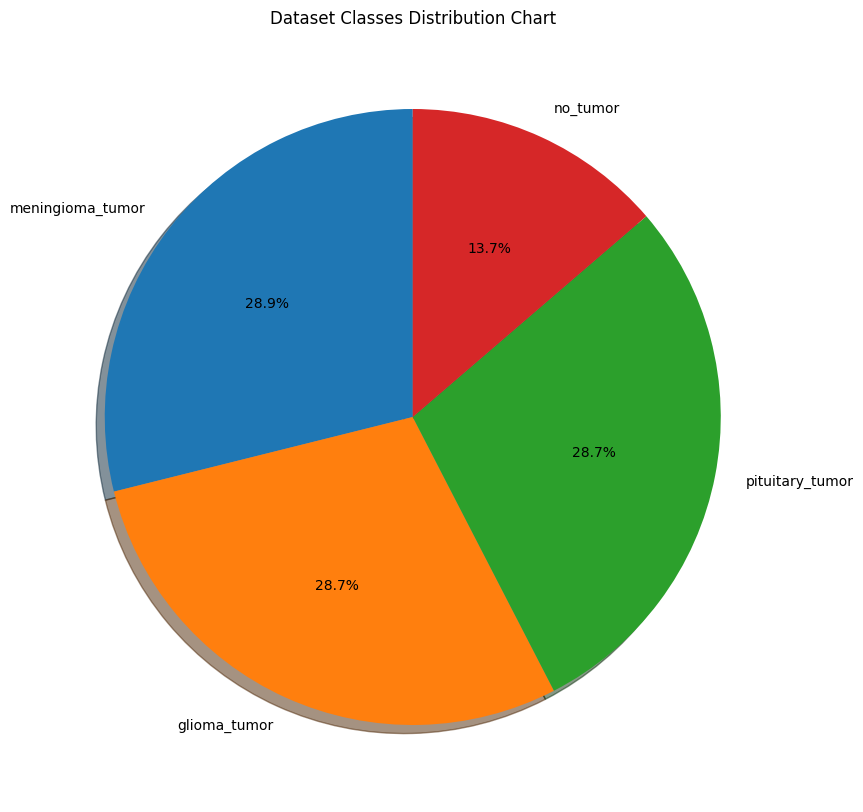

{'meningioma_tumor': 831, 'glioma_tumor': 825, 'pituitary_tumor': 826, 'no_tumor': 394}


In [ ]:


# Visualizing data distrubitons accordin to classes
class_names_train = os.listdir(DATA_PATH)

image_count = {}
for i in class_names_train:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) - 1

    
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        textprops=dict(color="black"),
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Dataset Classes Distribution Chart", color='black')
plt.show()
print(image_count)

In [ ]:
model = models.alexnet(pretrained= True)
for param in model.parameters():
    param.require_grad = True

fc = nn.Sequential(
    nn.Linear(1024,460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 5)
)

model.classifier = fc

model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(param.require_grad), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 219MB/s]


In [ ]:
total_step = len(train_loader)
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []

# Training 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        epoch_start_time = time.time()
        running_loss = 0.0
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time



arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

# Prediction
with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the ' + str(len(test_dataset)) + ' test images: {} %'.format(100 * correct / total))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: ignored

In [ ]:


x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

In [ ]:


import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

In [ ]:


plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn import metrics
# from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= class_names_train, title='Confusion matrix' , normalize= False)


print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")